The Adelaide data is available in the fds package in R, and contains electricity demands in Megawatts (MW) from Sunday to Saturday in Adelaide, Australia for 508 weeks. The demand is measured in 30 minute interval, therefore, there are 48 measurements taken per day. I have taken the data found in R, and put it into a .csv file.

In [4]:
from pandas import read_csv
import funweightclust as fwc
raw_adelaide = read_csv("data/Adelaide/adelaide.csv")
X = raw_adelaide["X"]
Y = raw_adelaide.filter(like="Y")


We will be analyzing only Sunday and Tuesday, and suppose that one can predict the afternoon demand measurements using the morning demand measurements. We will plot the demand curves for Sunday and Tuesday.

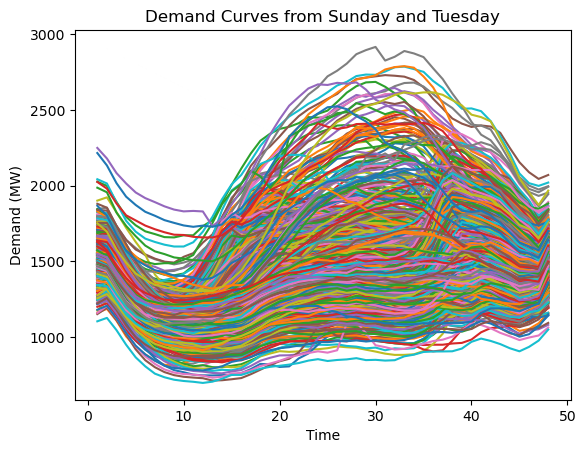

In [6]:
import matplotlib.pyplot as plt

demand_curves = Y.filter(regex="Sun|Tue")

plt.plot(X, demand_curves)
plt.title("Demand Curves from Sunday and Tuesday")
plt.xlabel("Time")
plt.ylabel("Demand (MW)")
plt.show()

Now I will separate our data into our predictor variables, and our response variables. The Sunday/Tuesday demand measurements for the first 12 hours are our predictor variables, and the Sunday/Tuesday for the next 12 hours are our response variables.

In [18]:
predictor_curves = demand_curves.iloc[:24].reset_index(drop=True)
response_curves = demand_curves.iloc[24:].reset_index(drop=True)

Text(0.5, 1.0, 'Response Curves on a BSpline Basis')

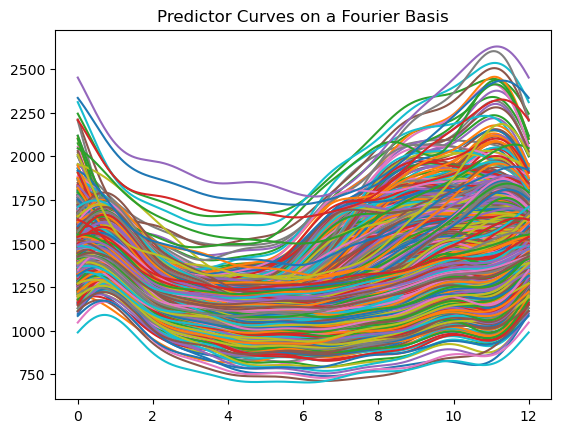

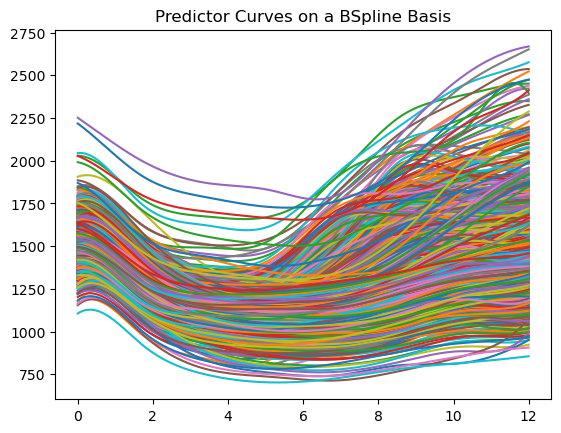

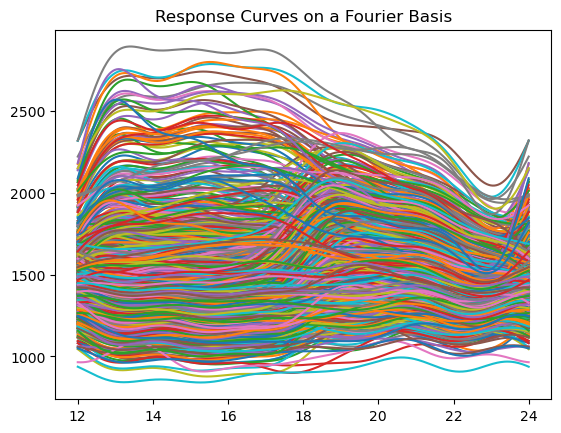

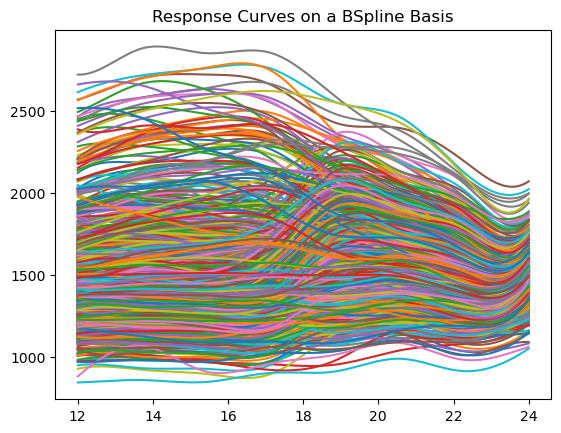

In [25]:
from process_data import create_functional_data
import numpy as np
from skfda.representation import FDataGrid
from skfda.representation.basis import FourierBasis, BSplineBasis

predictor_grid = np.linspace(0, 12, 24)
response_grid = np.linspace(12, 24, 24)

predictor_fourier = FDataGrid(data_matrix=predictor_curves.values.T, grid_points=predictor_grid).to_basis(FourierBasis(n_basis=10))
predictor_bspline = FDataGrid(data_matrix=predictor_curves.values.T, grid_points=predictor_grid).to_basis(BSplineBasis(n_basis=10))

predictor_fourier.plot()
plt.title("Predictor Curves on a Fourier Basis")

predictor_bspline.plot()
plt.title("Predictor Curves on a BSpline Basis")

response_fourier = FDataGrid(data_matrix=response_curves.values.T, grid_points=response_grid).to_basis(FourierBasis(n_basis=10))
response_bspline = FDataGrid(data_matrix=response_curves.values.T, grid_points=response_grid).to_basis(BSplineBasis(n_basis=10))

response_fourier.plot()
plt.title("Response Curves on a Fourier Basis")

response_bspline.plot()
plt.title("Response Curves on a BSpline Basis")


Based off of the images, I conclude that a B-Spline Basis represents the data better than a Fourier Basis. We will now be using FunWeightClust to determine whether an electricity demand curve is from Sunday or Tuesday.

FunWeightClust:  53.3 secs  |  Approx. remaining:       0.0 secs  |    100% complete 

        Model ModelY  K Threshold Complexity          BIC
1     AKBQKDK    EEI  2       0.1      68.00  -229,124.11
2      ABQKDK    VVI  2       0.1      69.00  -230,269.96
3    AKBKQKDK    VEI  2       0.1      62.00  -230,306.36
4   AKJBKQKDK    EVI  2       0.1      62.00  -231,588.56
5    AKBKQKDK    EVI  2       0.1      62.00  -231,588.56
6   AKJBKQKDK    VVI  2       0.1      63.00  -231,630.88
7    AKBKQKDK    VVI  2       0.1      63.00  -231,630.88
8     ABKQKDK    VVI  2       0.1      62.00  -231,654.93
9     ABKQKDK    EVI  2       0.1      61.00  -231,713.24
10  AKJBKQKDK    EEI  2       0.1      53.00  -231,774.90
11   AKBKQKDK    EEI  2       0.1      53.00  -231,774.90
12  AKJBKQKDK    VEI  2       0.1      54.00  -231,794.50
13    ABKQKDK    EEI  2       0.1      52.00  -231,798.84
14    ABKQKDK    VEI  2       0.1      53.00  -231,824.58
15   AKJBQKDK    EVI  2       0.1      61.0

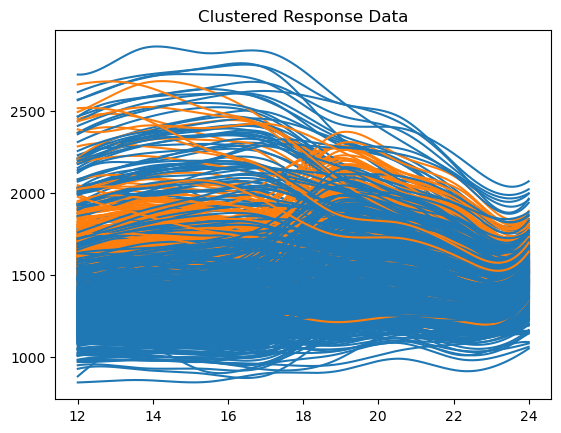

In [44]:
res = fwc.funweightclust(predictor_bspline, response_bspline, K = 2, model="all", modely = "all", init="kmeans", nb_rep = 1, threshold = 0.1, d_select="cattell")
response_bspline.plot(group=res.cl)
plt.title("Clustered Response Data")
plt.show()



The following cell contains our results. We have an ARI score of 0.58 and FunWeightClust clustered at an 88% accuracy rate (894/1016).

In [45]:
import sklearn.metrics as met

labels = np.repeat([0, 1], [508, 508])

print("ARI Score: ", met.adjusted_rand_score(res.cl, labels))
print("Confusion Matrix:\n", met.confusion_matrix(res.cl, labels))

ARI Score:  0.5769600171343696
Confusion Matrix:
 [[111 497]
 [397  11]]
